In [1]:
# Bir modülü eklemek için pip komutu kullanılacak, 
# jupyter defterinde kullanılabilmesi için 'sys' modülü dahil edilmesi gerekmektedir.
# PySimpleGUI ve PyGame grafiksel arabirim için kullanılacak olan modüldür.

# Pip is used to add a module to the python project,
# in order to download a new module throught pip we need to add the 'sys' module.
# PySimpleGUI and PyGame will be used for the GUI.

import sys
!{sys.executable} -m pip install PySimpleGUI
!{sys.executable} -m pip install pygame

In [2]:
# Projede kullanılacak diğer kütüphane/modüllerin dahil edilmesi.
# Adding the modules/libraries that will be used in the project
import numpy as np
import PySimpleGUI as sg
import pygame
import random
import matplotlib.pyplot as plt
import matplotlib
import pprint as pp

pygame 2.0.1 (SDL 2.0.14, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Grafiksel arabirimde datanın resmedilmesi için kullanılacak renklerin tanımlanması.
# In order to visualize data in the GUI the colors that will be used are defined.
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GREEN = (124, 252, 0)
RED = (255, 0, 0)
BLUE = (30, 144, 255)
YELLOW = (255, 215, 0)

# Grafiksel arabirimde her karenini boyutu ve kareler arası marjini (boşluğu).
# The height and weight of every block and the margin.
HEIGHT, WIDTH = 10, 10
MARGIN = 2

# Ortamın (ödüllendirme matris) boyutları.
# The environment's size.
grid_rows, grid_col = 50, 50

In [4]:
# Ajanın yapabileceği hareketler.
# Actions that the agent can take.
acts = ['up', 'right', 'down', 'left']

In [5]:
'''
Bu fonksiyon, PySimpleGUI modülünü kullanmaktadır. 
Basit bir arayüz oluşturduktan sonra fonksiyon çağrıldığında kullanıcın karşısına bir pencere çıkmaktadır.
Giriş ve çıkış konumlarının x ve y koordinatları kullanıcı ekleyebilmektedir.

This function uses the PySimpleGUI module.
A simple GUI pops up when this function is called.
The user can add two x,y tuples that will represent the starting and end point.
''';

def input_user():
    sg.theme('SandyBeach')
    layout = [[sg.Text("Giriş ve çıkış noktaları giriniz: ")],
              [sg.Text("Giriş [I]: "), sg.InputText()],
              [sg.Text("Giriş [J]: "), sg.InputText()],
              [sg.Text("Çıkış [I]: "), sg.InputText()],
              [sg.Text("Çıkış [J]: "), sg.InputText()],
              [sg.Button("OK")]
              ]
    window = sg.Window("Yazılım Laboratuvarı II - 3. Proje", layout)
    while True:
        event, values = window.read()
        if event == "OK" or event == sg.WIN_CLOSED:
            break
    window.close()
    return values

In [6]:
'''
Bu fonksiyon, maze'nin düzgün bir biçimde (rastgele değer, engel mi?) yazdırılması için kullanılmaktadır.

This function is used print out the maze that is randomly generated.
''';

def print_maze(R_Table):
    reward = R_Table.copy()
    for i in range(50):
        for j in range(50):
            if reward[i,j] == -50:
                reward[i,j] = -5
            if reward[i,j] == 50:
                reward[i,j]= 5
            
    reward_new = list()
    for i in range(50):
        temp = list()
        for j in range(50):
            temp.append([random.randrange(10), reward[i,j]])
        reward_new.append(temp)
    
    # Yazdırma döngüsü.
    # Loop used for printing.
    for row in reward_new:
        print(row)

In [7]:
'''
Bu fonksiyon rastgele olarak oluşturulan ödüllendirme matrisi engel.txt dosyasına yazdırmaktadır.
Dosyaya yazdırma biçimi: (satır sayısı, sütun sayısı, engel var mı?)

This function writes an output related to the randomly generated maze to the engel.txt file.
The way it's written: (row, column, is there an obstacle?)
''';

def write_to_file(maze):
    # Dosyanın açılması.
    # Opening a new file.
    f = open("engel.txt", "w")
    
    for i in range(len(maze)):
        for j in range(len(maze)):
            # Eğer matrisinin i ve j değeri -3 ise o zaman (i,j,B) biçimde yazdırılmaktadır (B = boş).
            # If maze[i,j] is equal to -3 then write (i,j,B), B meaning empty (boş).
            if maze[i, j] == -3:
                f.write(f"({i},{j},B) ")
            # Eğer matrisinin i ve j değeri -50 ise o zaman (i,j,K) biçimde yazdırılmaktadır (K = engel, kırmızı).
            # If maze[i,j] is equal to -50 then write (i,j,K), K meaning obstacle (kırmızı).
            elif maze[i, j] == -50:
                f.write(f"({i},{j},K) ")
        f.write("\n")
    f.close()

In [8]:
'''
Bu fonksiyon, PyGame modülünü kullanmaktadır.
Rastgele oluşturulan matrisin grafiksel arabirimde resmedilmesi için kullanılmaktadır.

This function uses the PyGame module.
The randomly generated matrix is visualized on a GUI.
''';

def pygame_visualization(maze):
    # PyGame penceresinin başlatılması.
    # Starting the PyGame window.
    pygame.init()
    
    # Pencerenin boyutlarının belirtilmesi.
    # Window size.
    WINDOW_SIZE = [600, 600]
    
    # Pencere boyutlarının atanması.
    # Assigning the size to the window.
    screen = pygame.display.set_mode(WINDOW_SIZE)
    
    # Pencerenin başlığının eklenmesi.
    # Adding a headline to the window.
    pygame.display.set_caption("Shortest Path with Q Learning")
    
    # Pencerenin kapanana kadar açık kalması için False değişkeninin tanımlanması (sonsuz döngü).
    # In order for the window to be open until it is closed.
    done = False
    
    # Pencerenin sayacı.
    # The windows counter.
    clock = pygame.time.Clock()

    while not done:
        # Eğer kullanıcı "X" (kapat) butonuna bastıysa pencerenin kapanması.
        # If user presses "X" (close) the window closes.
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                done = True
                
        # Ekranın arkasını siyah olarak belirlenmesi.
        # Background is black.
        screen.fill(BLACK)
        
        # Ödüllendirme matrisine göre renge uygun karelerin boyatılması.
        # Visualization according to the rewards matrix.
        for row in range(50):
            for column in range(50):
                color = WHITE
                if maze[row][column] == -50:
                    color = RED
                if maze[row][column] == 0:
                    color = BLUE
                if maze[row][column] == 50:
                    color = GREEN
                if maze[row][column] == 70:
                    color = YELLOW
                pygame.draw.rect(screen,
                        color,
                        [(MARGIN + WIDTH) * column + MARGIN,
                        (MARGIN + HEIGHT) * row + MARGIN,
                        WIDTH,
                        HEIGHT])
        clock.tick(60)
        
        # Pencerenin yenilenmesi.
        # The window's refreshing.
        pygame.display.flip()
    pygame.quit()

In [15]:
'''
Bu fonksiyon, ödüllendirme matrisine rastgele olarak engelleri (-5) değerleri eklemek için kullanılmaktadır.
Izgaranın %30'u engel olarak atanmaktadır.

This function is used to assign random obstacle values (-5) to the rewards matrix.
30% of the matrix has an obstacle value.
''';

def random_values(maze):
    # 900 iterasyon sonra ~750 karenin engel olarak belirlenmesi.
    # 900 iterations are enough for ~750 squares to be reassigned to an obstacle value.
    for i in range(900):
        maze[random.randint(0,49), random.randint(0,49)] = -50.
    return maze

In [10]:
# Q tablosu.
# Q table.
Q_Table = np.zeros((grid_rows, grid_col, 4))

# Ödüllendirme matrisinin ilk olarak tüm değeleri -3 olarak atanmaktadır.
# The rewards matrix's values are initially all -3.
R_Table = np.full((grid_rows, grid_col), -3.)

# Ödüllendirme matrisine -3 değeler atandıktan sonra rastgele olarak -5 engeller eklenmektedir.
# After the initialization, the obstacles are assigned (-5).
R_Table = random_values(R_Table)

# Rastgele olarak oluşturulan ödüllendirme matrisi engel.txt dosyaya yazdırılmaktadır.
# Rewards matrix is being written to engel.txt file.
write_to_file(R_Table)

# Rastgele değerlerle oluşturulan maze yazdırılmaktadır.
# Printing the rewards matrix (maze).
# print_maze(R_Table)

In [11]:
# İlk olarak giriş çıkış kareleri olmadan ödüllendirme matrisi gösterilmektedir.
# The matrix is visualized without the start and end point.
pygame_visualization(R_Table)

# Grafiksel arabirimden kullanıcının belirttiği değerler alınmaktadır.
# Start and end point values are requested from the user.
values = input_user()

# Sadece resmedilmek için kullanılacak yeni bir ödüllendirme matrisi oluşturulmaktadır.
# A copy of the rewards matrix is made just for visualization.
visualization_R_Table = R_Table.copy()

# Resmedilme için kullanıcak matrise kullanıcının belirttiği giriş çıkış kareleri eklenmektedir.
# The start and end points are added to the rewards matrix (copy).
visualization_R_Table[int(values[0]), int(values[1])] = 0.
visualization_R_Table[int(values[2]), int(values[3])] = 50.

# Resmedilme için kullanılan matris resmedilmektedir.
# The copy of the rewards matrix is used for visualization.
pygame_visualization(visualization_R_Table)

# Gerçek ödüllendirme matirisine sadece giriş karesi eklenmektedir.
# Adding the start point to the actual rewards matrix.
R_Table[int(values[2]), int(values[3])] = 50.

In [12]:
'''
Bu fonksiyon, ödüllendirme matrisindeki bir durumunun engel olup olmadığını kontrol etmektedir.
Kontrol ettikten sonra, eğer durum engel değilse False döner aksi takdirde True döner (engeldir).

This function finds out if the square at a given row and column index is an obstacle.
If it is an obstacle then it returns True, if it isn't an obstacle then it return False.
''';

def check_terminal(present_row_idx, present_col_idx):
    
    # Eğer bir karenin değeri -3 ise o zaman o engel değildir (beyaz bir karedir).
    # If the value is -3 then it is a white square (not an obstacle, passable).
    if R_Table[present_row_idx, present_col_idx] == -3.:
        return False
    # Diğer durumlarda engeldir (kırmızı ya da yeşil kare).
    # In other cases it's either a red or green square (an obstacle or the end point)
    else:
        return True

'''
Bu fonksiyon, ızgarada rastgele olarak engel olmaması koşuluyla yeni bir başlangıç karesi belirlemektedir.
Eğer rastgele olara oluşturulan x, y değerleri engel bir karenin karşılığı ise o zaman engel olmayan bir kareyi
buluncaya kadar rastgele x, y değeleri oluşturulmaktadır.

This function takes a random non-terminal square from the grid.
If a randomly taken square is a terminal it continues iterating (choosing a random square) until it finds a non-terminal square. 
''';

def init_location():

    # Yeni bir x, y koordinatların değeleri rastgele olarak oluşturulmaktadır.
    # A random x, y value is generated.
    present_row_idx = np.random.randint(grid_rows)
    present_col_idx = np.random.randint(grid_col)
    
    # Eğer oluşturulan değerler engel ise o zaman tekrar oluşturulmaktadır.
    # If the value is terminal, generating it again.
    while check_terminal(present_row_idx, present_col_idx):
        present_row_idx = np.random.randint(grid_rows)
        present_col_idx = np.random.randint(grid_col)
        
    return present_row_idx, present_col_idx

'''
Epsilon-Greedy, keşif (exploration) ve sömürü (explotation) arasında denge kurmanın basit bir yöntemidir.
Bu fonksiyonda, Epsilon-Greedy Algoritması uygulanmaktadır.

Epsilon-Greedy is a simple method of balancing exploration and explotation.
This function is based on Epsilon-Greedy's algorithm.
''';

def select_next_act(present_row_idx, present_col_idx, epsilon):
    
    # Rastgele olarak oluşturulan bir değer eğer ε'den daha küçük ise Q tablosundan bu durum için en uygun değer seçilmektedir.
    # If a randomly generated value is less than ε, the most appropriate value for this situation is selected from the Q table.
    if np.random.random() < epsilon:
        return np.argmax(Q_Table[present_row_idx, present_col_idx])
    
    # Eğer değilse, 4 hareketten biri seçilmektedir.
    # If not, one of the 4 actions is chosen.
    else:
        return np.random.randint(4)

'''
Bu fonksiyonda, mevcut durumuna göre yeni bir durum belirlenmektedir.
In this function, a new state is determined according to its current state.
''';

def select_next_loc(present_row_idx, present_col_idx, action_index):
    # Mevcut durumlar alınmaktadır.
    # Current situations are received.
    row_idx_new = present_row_idx
    col_idx_new = present_col_idx
    
    # Yeni durum belirlenmektedir.
    # The new situation is determined.
    if acts[action_index] == 'up' and present_row_idx > 0:
        row_idx_new -= 1
    elif acts[action_index] == 'right' and present_col_idx < grid_col - 1:
        col_idx_new += 1
    elif acts[action_index] == 'down' and present_row_idx < grid_rows - 1:
        row_idx_new += 1
    elif acts[action_index] == 'left' and present_col_idx > 0:
        col_idx_new -= 1
        
    return row_idx_new, col_idx_new

'''
Bu fonksiyon, ajanın başlangıç noktasından çıkışa giden yolu bulmak için kullanılmaktadır.

This function is used to find the path from the starting point of the agent to the exit.
''';

def find_path(start_row_index, start_column_index):
    
    # Eğer başlangıç noktası bir engel ise boş bir liste döndürmektedir.
    # Returns an empty list if the starting point is an obstacle.
    if check_terminal(start_row_index, start_column_index):
        return []
    
    # Başlangıç noktası engel değilse devam edilmektedir.
    # If the starting point is not an obstacle, continue.
    else:
        present_row_idx, present_col_idx = start_row_index, start_column_index
        shortest_path = []
        shortest_path.append([present_row_idx, present_col_idx])
        # Kare engel değilken devam edilmektedir.
        # Continues when the square is not obstacle.
        while not check_terminal(present_row_idx, present_col_idx):
            # Bir sonraki hareket belirlenmektedir.
            # The next move is determined.
            action_index = select_next_act(present_row_idx, present_col_idx, 1.)
            
            # Yeni bir konuma geçmekte ve geçilen konum listeye eklenmektedir.
            # Moves to a new location and the new location is added to the list.
            present_row_idx, present_col_idx = select_next_loc(present_row_idx, present_col_idx, action_index)
            shortest_path.append([present_row_idx, present_col_idx])
            
    return shortest_path

In [13]:
# Eğitmek için parametreler belirlenmektedir.
# Parameters are set for training.

# Rastgele hareket yerine en iyi hareket belirleme olasılığı (ε - epsilon).
# Best probability of motion determination (ε - epsilon) instead of random motion.
epsilon = 0.9

# Gelecekteki ödüllendirmeler için indirim faktörü  (γ - gamma).
# Discount factor (- gamma) for future rewards.
gamma = 0.9

# Ajanın öğrenme oranı (α - alfa).
# The agent's learning rate (α - alpha).
alpha = 0.9

# Adım sayısı için kullanılmaktadır.
# Used for the number of steps.
step_number = []

# Maliyet (ödüllendirme) listesi için kullanılmaktadır.
# Used for the cost (rewarding) list.
cost_list = []

# Eğitme 100k bölümden geçmektedir.
# Training for 100k epochs.
for epoch in range(100000):
    
    # Her bölümde adım sayısını tutmaktadır.
    # Keeps the number of steps in each section.
    a = 0
    
    # Her bölümde ödüllendirme hesaplaması yapmaktadır.
    # Calculates the rewarding in each section.
    b = 0
    
    # Başlangıç konumu alınmaktadır.
    # Starting position is taken.
    row_index, column_index = init_location()

    # Ajan, engele rastlanana kadar hareket etmeye devam etmektedir.
    # The agent continues to move until the obstacle is encountered.
    while not check_terminal(row_index, column_index):
        
        # Bir sonraki hareket belirlenmektedir.
        # The next move is determined.
        action_index = select_next_act(row_index, column_index, epsilon)
        
        # Adım sayısı güncellenmektedir.
        # The step count is updated.
        a = a+1

        # Mevcut hareketi yapmakta ve bir sonraki duruma geçmektedir (yeni bir konuma geçiş).
        # Makes the current move and moves on to the next state (transition to a new position).
        previous_row_idx, previous_col_idx = row_index, column_index
        row_index, column_index = select_next_loc(row_index, column_index, action_index)
        
        # Maliyet (ödüllendirme) hesabı yapılmaktadır.
        # Cost (rewarding) calculation.
        b = b + R_Table[row_index, column_index]
    
        # Ödüllendirme alınmakta ve geçici fark hesaplanmaktadır.
        # The reward is received and the temporary difference is calculated.
        reward = R_Table[row_index, column_index]
        old_q_value = Q_Table[previous_row_idx, previous_col_idx, action_index]
        
        # TD = r + (γ * max(Q(x,y))) - Qold(x, y) Bellman Eşitliği (Equation)
        bellman_equation = reward + (gamma * np.max(Q_Table[row_index, column_index])) - old_q_value

        # Q tablosu güncellenmektedir.
        # The Q table is updated.
        new_q_value = old_q_value + (alpha * bellman_equation)
        Q_Table[previous_row_idx, previous_col_idx, action_index] = new_q_value
        
    # Her bölümde alınan adım sayısı kaydedilmektedir.   
    # The number of steps taken in each epoch is recorded.
    step_number.append(a)
    
    # Her bölümde maliyet hesabı sonucu kaydedilmektedir.
    # The result of the cost calculation is recorded in each epoch.
    cost_list.append(b)
    
    print('Iteration: ' + str(epoch), end='\r')

print('TRAINING - DONE.')

TRAINING - DONE.


In [14]:
# Girişten çıkısa kadar en kısa yol bulunulmaktadır. Yol bulunmaması durumunda giriş konumu bir engelin konumunun karşılığıdır.
# The shortest way is found from the entrance to the exit. If there is no road, the entry position corresponds to the position of an obstacle.
path = find_path(int(values[0]), int(values[1]))

if not a: 
    print("PATH NOT FOUND, OR START IS ON TERMINAL STATE.")
else: 
    print("PATH FOUND.")

end_point = list()
end_point.append(int(values[2]))
end_point.append(int(values[3]))

# Eğer bulunan yolun son koordinatı çıkışın son koordinatı ile aynı ise, eğitme yeterlidir.
# If the last coordinate of the found path is the same as the last coordinate of the exit, training is sufficient.
if(end_point == path[len(path)-1]):
    print("WELL TRAINED.")

# Eğer değilse, biraz daha eğitirilmesi gerekmetedir.
# If not, needs to be trained a little more.
else:
    print("TRAIN AGAIN.")

PATH FOUND.
WELL TRAINED.


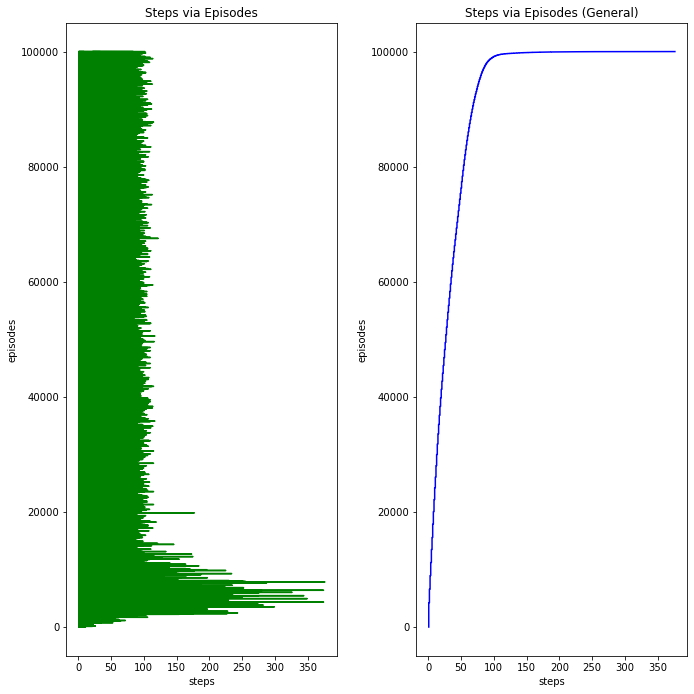

In [16]:
episodes = np.linspace(0, 100000, 100000)

step_list = step_number.copy()
step_list.sort()

cost = cost_list.copy()
cost.sort()

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(step_number, episodes, 'g')
plt.xlabel("steps")
plt.ylabel("episodes")
plt.title("Steps via Episodes")

plt.subplot(1,2,2)
plt.plot(step_list, episodes, 'b')
plt.xlabel("steps")
plt.ylabel("episodes")
plt.title("Steps via Episodes (General)")

plt.tight_layout(pad = 2)

'''
Bu kısımda grafikler çizdirilmektedir.
Birinci grafik, bölümlere göre adım sayısını göstermektedir.
İkinci grafik, birinci grafiğin daha genel bir hali göstermektedir.

In this section, graphics are drawn.
The first graph shows the number of steps via epochs.
The second graph shows a more general form of the first graph.
''';

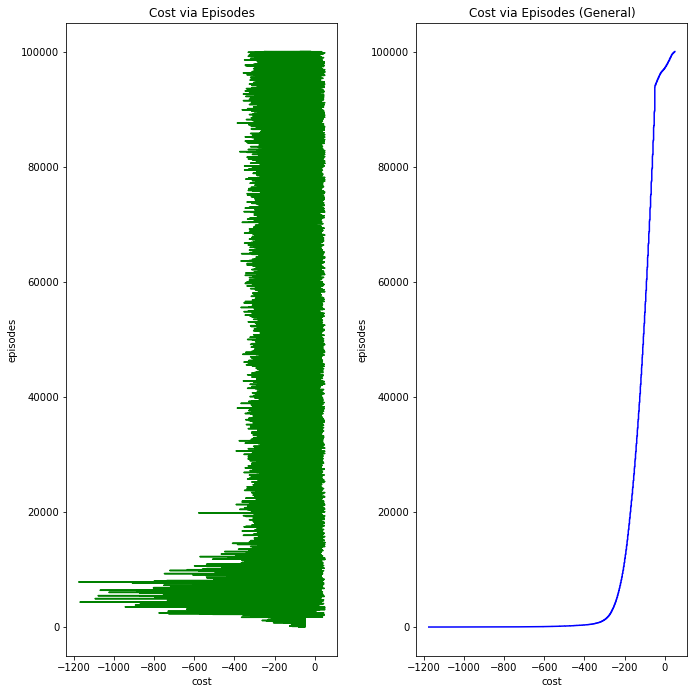

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(cost_list, episodes, 'g')
plt.xlabel("cost")
plt.ylabel("episodes")
plt.title("Cost via Episodes")

plt.subplot(1,2,2)
plt.plot(cost, episodes, 'b')
plt.xlabel("cost")
plt.ylabel("episodes")
plt.title("Cost via Episodes (General)")

plt.tight_layout(pad = 2)

'''
Bu kısımda grafikler çizdirilmektedir.
Birinci grafik, bölümlere göre maliyet hesaplamasını göstermektedir.
İkinci grafik, birinci grafiğin daha genel bir hali göstermektedir.

In this section, graphics are drawn.
The first chart shows the cost calculation via episodes.
The second graph shows a more general form of the first graph
''';

In [18]:
# Q_Table

In [19]:
# Resmedilme burada yapılmaktadır.
# Visualization.
visualization_R_Table = R_Table.copy()

# Yolun konumları 70 olarak belirlenmekte.
# The positions of the road are determined as 70.
for node in path:
    visualization_R_Table[node[0], node[1]] = 70
visualization_R_Table[int(values[0]), int(values[1])] = 0
visualization_R_Table[int(values[2]), int(values[3])] = 50

# for row in visualization_R_Table:
#   print(row)

In [20]:
# Resmedilme yapılır.
# Visualization.
pygame_visualization(visualization_R_Table)